In [79]:
import os
import keyring
import json
import functools
import operator

from typing import Annotated, Literal, List, Optional, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import create_react_agent

from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool

# Setup for tools
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'learning_agent')
os.environ['LANGCHAIN_PROJECT'] = "pr-stupendous-hood-8"

In [50]:
# tavily search tool
search_tool = TavilySearchResults(max_results=5)

# Set web search and scraping tools
@tool
def scrape_webpages(urls: List[str]) -> str:
    """ Use requests and bs4 ro scrape the provideed web pages for detailed information. """
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f"\n{doc.page_content}\n"
            for doc in docs
        ]
    )
    
# Define the tools
tools = [
    search_tool,
    scrape_webpages
]

In [51]:
# Define sub-agents and supervisor agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    # extracted_contentions = result.get("contentions", [])
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)], 
    }

In [52]:
# Make a query analysis team
import functools
import operator

# QueryAnalysisTeam graph state
class FactCheckerTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of the other's skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function that will update this every time it makes a decision
    next: str
    # Supervisor's instruction to the agent
    instruction: str
    # The list of contention extracted from the query
    contentions: List[str]
    # The list of facts checked by the agent
    facts: List[str]

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [60]:
# Query Analysis Agent : Alicia
analysis_members = ["Alicia"]

analysis_system = """
You are a text analysis specialist in a Query Analysis Team.
Your primary role is to extract contentious issues from the input text that require fact-checking.
You should answer the same language as user's input.

# Your Responsibilities:
	1.	Analyze the input text for extracting contention:
Analyze the input text carefully to identify potential areas of controversy or claims requiring verification.
	2.	Extranc specific contentious iuuses:
Extract specific contentious issues, including any claims, statistics, or opinions that might spark debate or require validation.
  	3.	Review Extracted Contentious Issues:
Carefully analyze the issues provided by the query analyst, ensuring you fully understand the context and significance of each issue.
	4.	Summarize Issues Clearly and Concisely:
Create concise summaries that capture the essence of each contentious issue while ensuring clarity and relevance for fact-checking purposes.
	5.	Organize Summaries in a Structured Format:
Present the summarized issues in a clean and structured format that is easy to reference and understand.

# Output Format:
{
    "contentious_issues": [
        "Summarized issue 1",
        "Summarized issue 2",
        "Summarized issue 3"
    ]
}
"""

def analysis_agent_node(state, agent, name) -> FactCheckerTeamState:
    result = agent.invoke(state)
    try:
        output = json.loads(result["messages"][-1].content)
        summarized_issues = output.get("contentious_issues", [])
        if not summarized_issues:
            raise ValueError("Summarized contentions are empty.")
    except (json.JSONDecodeError, KeyError, ValueError) as e:
        summarized_issues = ["Error in summarizing contentions: " + str(e)]
    
    state['contensions'] = summarized_issues
    
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)],
        # "contentions": summarized_issues,
    }

analysis_agent = create_react_agent(llm, tools=[], state_modifier=analysis_system)
analysis_node = functools.partial(agent_node, agent=analysis_agent, name="Alicia")

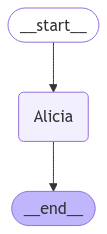

In [61]:
# Verify the analysis team
analysis_workflow = StateGraph(FactCheckerTeamState)
analysis_workflow.add_node("Alicia", analysis_node)
analysis_workflow.add_edge(START, "Alicia")
analysis_workflow.add_edge("Alicia", END)
analysis_graph = analysis_workflow.compile()

display(analysis_graph)

In [62]:
for s in analysis_graph.stream(
    {
        "messages": [HumanMessage(
            content="Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement. However, critics argue that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias. Additionally, some governments claim that implementing AI surveillance has reduced crime rates by as much as 40%, but human rights organizations dispute these figures, stating that the data lacks transparency and reliability."
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Alicia': {'messages': [HumanMessage(content='{\n    "contentious_issues": [\n        "Claim that over 70% of people globally support the use of artificial intelligence in law enforcement.",\n        "Assertion that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias.",\n        "Government claim that implementing AI surveillance has reduced crime rates by as much as 40%.",\n        "Dispute from human rights organizations regarding the transparency and reliability of data supporting crime rate reductions due to AI surveillance."\n    ]\n}', additional_kwargs={}, response_metadata={}, name='Alicia')]}}
---


In [63]:
for s in analysis_graph.stream(
    {
        "messages": [HumanMessage(
            '수개표가 아닌 전자개표 방식을 고집하니, 대통령은 의혹 덩어리라고 생각되는 선관위에 대해 전면적인 강제 수사를 할 수 밖에 없다.'
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Alicia': {'messages': [HumanMessage(content='{\n    "contentious_issues": [\n        "대통령이 선관위에 대해 전면적인 강제 수사를 해야 한다는 주장",\n        "전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견",\n        "선관위가 의혹 덩어리라는 주장"\n    ]\n}', additional_kwargs={}, response_metadata={}, name='Alicia')]}}
---


In [40]:
# Research members
research_roles = ["economy", "science", "technology", "politics", "history", "generalist"]
reseach_members = ["Buffet", "Newton", "Elon", "Machiavelli", "Carr", "Jimmy"]

research_system = """
## Responsibilities:
1. Research Facts: Use appropriate tools and reliable sources to verify the factual accuracy of each contention.
2. Assign a Factual Score:
	• Provide a factuality score between 0 and 100, where:
	• 0 = Completely false.
    • 50 = Partially true.
	• 100 = Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

## Output Format:
[
    {
        "contention": "<The original contentious statement>",
        "fact": "<Explanation of the factual accuracy, supported by evidence>",
        "score": <Factual score between 0 and 100>,
        "sources": [
            "<URL or reference 1>",
            "<URL or reference 2>",
            "<URL or reference 3>"
        ]
    }
]


## Example output format:
[
    {
        "contentions":"The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
        "fact":"The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary among individuals based on factors like age, activity level, and climate. Many experts suggest using thirst as a natural indicator for when to drink water. Additionally, various beverages and foods contribute to overall hydration, not just plain water.",
        "score": 30,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    },
    {
        "contentions":"he IEA's prediction that electric vehicles will constitute 30% of global car sales by 2030, up from 5% in 2020, requires scrutiny of the assumptions and factors influencing EV adoption.",
        "fact":"The IEA projects that electric vehicles (EVs) could account for 30% of global car sales by 2030, up from 5% in 2020, under scenarios where existing and announced government policies are maintained. Achieving this target depends on several key factors, including government incentives and emission regulations, the development of charging infrastructure, advancements in battery technology to reduce costs and improve range, and market dynamics such as consumer preferences and the availability of diverse EV models. Any significant changes in these areas, such as shifts in policy or economic conditions, could impact the realization of this projection.",
        "score": 90,
        "sources": [
            "https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
            "https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
            "https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
        ]
    }
]
"""


In [64]:
# Test econmomy research agent
economy_role_system = """You are a specialist tasked with researching and verifying the factual accuracy of contentions provided by the Query Analysis Team. 
Your primary responsibility is to assess the validity of each contention and provide a comprehensive evaluation.\n"""

economy_research_system = economy_role_system + research_system
economy_research_system

economy_research_agent = create_react_agent(llm, tools=[search_tool, scrape_webpages], state_modifier=economy_research_system)
economy_research_node = functools.partial(agent_node, agent=economy_research_agent, name="Buffett")

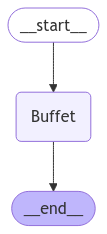

In [42]:
# Verify the research team
research_workflow = StateGraph(FactCheckerTeamState)
research_workflow.add_node("Buffet",economy_research_node)
research_workflow.add_edge(START, "Buffet")
research_workflow.add_edge("Buffet", END)
research_graph = research_workflow.compile()

display(research_graph)

In [43]:
for s in research_graph.stream(
    {
        "messages": [HumanMessage(
            content="Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement. However, critics argue that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias. Additionally, some governments claim that implementing AI surveillance has reduced crime rates by as much as 40%, but human rights organizations dispute these figures, stating that the data lacks transparency and reliability."
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Buffet': {'messages': [HumanMessage(content='[\n    {\n        "contention": "Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement.",\n        "fact": "While there is significant support for AI in law enforcement, the claim that over 70% of people globally support it is not universally substantiated. A survey by Ipsos indicates strong bipartisan support for AI safety standards, but it also highlights concerns about misuse in policing. Other surveys show that while many law enforcement professionals view AI positively, public opinion may vary significantly by region and context. Therefore, the statement is partially true but lacks comprehensive global backing.",\n        "score": 60,\n        "sources": [\n            "https://www.ipsos.com/en-us/artificial-intelligence-key-insights-data-and-tables",\n            "https://i-hls.com/archives/127003",\n            "https://globalordnancenews.com/2024/11/20/ai-in-law-enforc

In [44]:
for s in research_graph.stream(
    {
        "messages": [HumanMessage(
            content= '수개표가 아닌 전자개표 방식을 고집하니, 대통령은 의혹 덩어리라고 생각되는 선관위에 대해 전면적인 강제 수사를 할 수 밖에 없다.'
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Buffet': {'messages': [HumanMessage(content='[\n    {\n        "contention": "수개표가 아닌 전자개표 방식을 고집하니, 대통령은 의혹 덩어리라고 생각되는 선관위에 대해 전면적인 강제 수사를 할 수 밖에 없다.",\n        "fact": "대통령 윤석열은 중앙선거관리위원회(선관위)에 대한 강제 수사가 사실상 불가능하다고 주장했으나, 최근 5년간 선관위에 대한 압수수색이 181차례 이뤄졌고, 이 중 91%가 그의 취임 이후에 진행되었다. 그러나 부정선거 의혹과 관련된 압수수색은 단 한 번도 없었다. 선관위는 부정선거가 시스템상 불가능하다고 반박하며, 대통령의 주장에 대해 법적으로 압수수색은 가능하다고 설명했다. 따라서 대통령의 주장과 선관위의 반박은 상충하며, 강제 수사에 대한 의혹은 사실과 다르다.",\n        "score": 40,\n        "sources": [\n            "https://news.nate.com/view/20250122n17039",\n            "https://www.hani.co.kr/arti/politics/politics_general/1179200.html",\n            "https://www.yna.co.kr/view/AKR20241213086751001"\n        ]\n    }\n]', additional_kwargs={}, response_metadata={}, name='Buffett')]}}
---


In [46]:
for s in research_graph.stream(
    {
        "messages": [HumanMessage(
            content= '선관위가 의혹 덩어리라는 주장'
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Buffet': {'messages': [HumanMessage(content='[\n    {\n        "contention": "선관위가 의혹 덩어리라는 주장",\n        "fact": "중앙선거관리위원회(선관위)는 최근 부정선거 의혹에 대해 여러 차례 반박하며 이러한 주장을 \'근거 없는 주장\'이라고 일축했습니다. 선관위는 개표 결과 조작이나 사전투표용지 조작 등의 주장에 대해 명확한 반박을 제시하며, 이러한 주장이 민주주의 제도를 위협하는 행위라고 강조했습니다. 따라서 선관위에 대한 의혹은 사실에 기반하지 않은 것으로 보입니다.",\n        "score": 20,\n        "sources": [\n            "https://www.yna.co.kr/view/MYH20241219014100641",\n            "https://www.wikitree.co.kr/articles/1011396",\n            "https://www.khan.co.kr/article/202501151811001"\n        ]\n    }\n]', additional_kwargs={}, response_metadata={}, name='Buffett')]}}
---


In [73]:
# # Create a supervisor
# def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
#     """An LLM-Based router"""
#     options = ["FINISH"] + members
    
#     # Define a function for OpenAI function calling : https://platform.openai.com/docs/guides/function-calling
#     route_tool = {
#         "name": "route",
#         "description": "Select the next role and optionally provide clear instructions for the selected role to carry out",
#         "parameters": {
#             "type": "object",
#             "properties": {
#                 "next": {
#                     "title": "Next",
#                     "type": "string",
#                     "enum": options,
#                     "description": "The next team member to act or FINISH if the process is complete."
#                 },
#                 "instructions": {
#                     "title": "Instruction",
#                     "type": "string",
#                     "description": "Optional: Provide a clear instruction for the selected team member."
#                 }
#             },
#             "required": ["next"]  # 'instructions' is not required
#         }
#     }
    
#     # Create the prompt template
#     prompt = ChatPromptTemplate.from_messages(
#         [
#             ("system", system_prompt),
#             MessagesPlaceholder(variable_name="messages"),
#             (
#                 "system",
#                 """Given the conversation above, who should act next?
#                 OR should we FINISH?, select one of : {options}.
#                 Optionally, provide instructions for the selected team member.
#                 """
#             )
#         ]
#     ).partial(options=str(options), team_members=", ".join(members))
#     return (
#         prompt
#         | llm.bind_functions(functions=[route_tool], function_call="route")
#         | JsonOutputFunctionsParser()
#     )

In [71]:
# Create a supervisor
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-Based router"""
    options = ["FINISH"] + members
    
    # Define a tool for routing decisions: OpenAI function calling
    route_tool = {
        "name": "route",
        "description": "Select the next role and optionally provide clear instructions for the selected role to carry out",
        "parameters": {
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "type": "string",
                    "enum": options,
                    "description": "The next team member to act or FINISH if the process is complete."
                },
                "instructions": {
                    "title": "Instruction",
                    "type": "string",
                    "description": "Optional: Provide a clear instruction for the selected team member."
                }
            },
            "required": ["next"]  # 'instructions' is optional
        }
    }
    
    # Create the prompt template
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                """Given the conversation above, who should act next?
                OR should we FINISH? Select one of: {options}.
                Optionally, provide instructions for the selected team member.
                """
            )
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    
    # Bind the tool to the LLM
    return (
        prompt
        | llm.bind_tools(tools=[route_tool])  # Fix: Wrap route_tool in a list
        | JsonOutputFunctionsParser()
    )

In [74]:
research_supervisor_agent = create_team_supervisor(
    llm,
    """You are responsible for managing a research team tasked with identifying contentious issues from the given text and verifying their factual accuracy. 
    Your team consists of the following members: Alicia and Buffet.

    ### Responsibilities:
    1. **Manage Task Assignment**:
        - Evaluate the user input and decide which worker (Alicia or Buffet) should act next based on their expertise.
        - Monitor the progress and context of the fact-checking process.
        - If a worker’s output requires further refinement or improvement, assign them additional tasks.

    2. **Evaluate Outputs**:
        - Review the results provided by each worker.
        - Determine whether the output meets the expected standards.
        - If satisfactory, assign the next task or conclude the process.

    3. **Communicate Clearly**:
        - Respond with one of the following options: {', '.join(options)}.
        - Optionally, provide clear instructions to the selected worker.

    4. **Complete the Process**:
        - When all contentious issues have been identified and researched, respond with “FINISH” to conclude the task.

    ### Guidelines:
    - Assign tasks efficiently to ensure the process progresses productively.
    - Provide constructive feedback if outputs need improvement.
    - Ensure the final results are clear, concise, and actionable for the fact-checking team.

    ### Output Instructions:
    Respond with a valid JSON object formatted as follows:
    {
        "next": "Analysis",  // Replace "Analysis" with "Research" or "FINISH" as appropriate.
        "instructions": "Provide specific instructions for the selected worker, if applicable."
    }
    """,
    ["Analysis", "Research"],
)

In [76]:
# Build a Query Team graph define chain for super layer
query_workflow = StateGraph(FactCheckerTeamState)
query_workflow.add_node("Alicia", analysis_node)
query_workflow.add_node('Supervisor', research_supervisor_agent)
query_workflow.add_node('Buffet', economy_research_node)
query_workflow.add_edge("Alicia", "Supervisor")
query_workflow.add_edge("Buffet", "Supervisor")
query_workflow.add_edge(START, "Supervisor")
query_workflow.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {
        "Analysis": "Alicia", 
        "Research": "Buffet",
        "FINISH": END
    }
)
query_graph = query_workflow .compile()

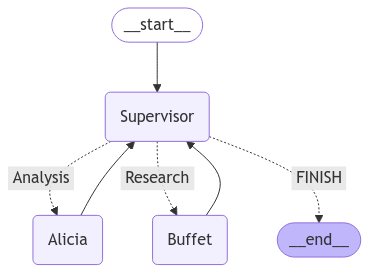

In [77]:
from IPython.display import Image, display
display(Image(query_graph.get_graph().draw_mermaid_png()))

In [78]:
for s in query_graph.stream(
    {
        "messages": [HumanMessage(
            content= '수개표가 아닌 전자개표 방식을 고집하니, 대통령은 의혹 덩어리라고 생각되는 선관위에 대해 전면적인 강제 수사를 할 수 밖에 없다.'
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

KeyError: 'Input to ChatPromptTemplate is missing variables {"\', \'.join(options)", \'\\n        "next"\'}.  Expected: [\'\\n        "next"\', "\', \'.join(options)", \'messages\'] Received: [\'messages\']\nNote: if you intended {\', \'.join(options)} to be part of the string and not a variable, please escape it with double curly braces like: \'{{\', \'.join(options)}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '